# Task 2: Recommendation Engine - K Nearest Recommendation in simlar location


## Setting up the Notebook

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pathlib import Path



## Load the Data

For this example, we use a simplified version of the dataset with only 2k+ data samples, each with only a subset of features.

In [7]:
df_sample = pd.read_csv('data/sg-property-prices-simplified.csv')

df_sample.head()

,listing_id,title,property_name,property_type,built_year,num_beds,num_baths,size_sqft,planning_area,price
0,799762,hdb flat for sale in 524 ang mo kio avenue 5,hdb-ang mo kio,hdb 3 rooms,1980.0,2.0,2.0,732,ang mo kio,419000.0
1,896907,4 bed condo for sale in kopar at newton,kopar at newton,condo,2023.0,4.0,4.0,1528,novena,3727500.0
2,445021,4 bed condo for sale in nouvel 18,nouvel 18,condo,2014.0,4.0,3.0,2476,newton,8013600.0
3,252293,hdb flat for sale in 467 jurong west street 41,hong kah ville,hdb,1985.0,3.0,2.0,1302,jurong west,682500.0
4,926453,hdb flat for sale in 664b punggol drive,waterway sunbeam,Hdb 5 Rooms,2016.0,3.0,2.0,1184,punggol,764400.0


In [8]:
df_train = pd.read_csv("../../../clean_data/train_preproc.csv", index_col=0)
df_train

,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,...,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
0,hdb,1988,3.0,2.0,1115,116,1.414399,103.837196,yishun south,yishun,...,1079.757868,1231.474343,1.143726e+06,5.0,223.00,6.620452e+05,0.573567,2.0,1,0
1,hdb,1992,4.0,2.0,1575,375,1.372597,103.875625,serangoon north,serangoon,...,1079.757868,2514.468039,3.670975e+06,6.0,262.50,6.620452e+05,1.728895,3.0,1,0
2,condo,2022,4.0,6.0,3070,56,1.298773,103.895798,mountbatten,marine parade,...,1154.798804,2011.903265,4.159877e+06,10.0,307.00,2.919816e+06,1.315256,5.0,0,1
3,condo,2023,3.0,2.0,958,638,1.312364,103.803271,farrer court,bukit timah,...,1154.798804,2468.346271,5.576084e+06,5.0,191.60,2.919816e+06,0.723885,4.0,0,1
4,condo,2026,2.0,1.0,732,351,1.273959,103.843635,anson,downtown core,...,1154.798804,1590.161473,4.853464e+06,3.0,244.00,2.919816e+06,0.370022,16.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20091,condo,2026,2.0,2.0,635,605,1.385938,103.834466,tagore,ang mo kio,...,1154.798804,1634.952055,2.355193e+06,4.0,158.75,2.919816e+06,0.150007,4.0,1,0
20092,condo,2026,2.0,2.0,883,137,1.315948,103.857589,lavender,kallang,...,1154.798804,1106.259542,2.256485e+06,4.0,220.75,2.919816e+06,0.442631,6.0,0,1
20093,condo,2023,4.0,4.0,1378,340,1.315961,103.836848,moulmein,novena,...,1154.798804,1662.211716,3.637860e+06,8.0,172.25,2.919816e+06,0.422131,5.0,0,1
20094,hdb,2017,3.0,2.0,1205,402,1.440753,103.806671,woodlands east,woodlands,...,1079.757868,1229.137405,8.223176e+05,5.0,241.00,6.620452e+05,0.632423,8.0,1,0


In [9]:
df_test = pd.read_csv("../../../clean_data/test_preproc.csv", index_col=0)
df_test

,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,...,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
0,condo,2022.0,1.0,1.0,463,250.000000,1.344334,103.878690,upper paya lebar,serangoon,...,1154.798804,2514.468039,3.670975e+06,2.0,231.500000,2.919816e+06,0.261673,3.00000,0,1
1,condo,2017.0,3.0,3.0,1033,463.000000,1.380281,103.943878,pasir ris west,pasir ris,...,1154.798804,2533.923372,2.735870e+06,6.0,172.166667,2.919816e+06,1.001264,4.00000,1,0
2,condo,2007.0,1.0,1.0,570,646.000000,1.294668,103.850074,bras basah,museum,...,1154.798804,837.848249,2.212662e+06,2.0,285.000000,2.919816e+06,0.251350,2.00000,1,0
3,hdb,2017.0,3.0,2.0,1216,968.000000,1.373120,103.746094,keat hong,choa chu kang,...,1079.757868,1276.588235,7.643136e+05,5.0,243.200000,6.620452e+05,0.767490,8.00000,1,0
4,hdb,1973.0,3.0,2.0,936,370.844848,1.341468,103.849047,braddell,toa payoh,...,1079.757868,1012.970588,1.506176e+06,5.0,187.200000,6.620452e+05,0.767490,2.00000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6961,bungalow,2009.0,5.0,6.0,8000,29.000000,1.249534,103.844281,sentosa,southern islands,...,7619.946019,6499.992933,1.522314e+07,11.0,727.272727,1.702708e+07,2.992831,4.79921,1,0
6962,semi-detached house,2010.0,5.0,7.0,6974,370.844848,1.332492,103.800004,hillcrest,bukit timah,...,5253.011811,2468.346271,5.576084e+06,12.0,581.166667,7.704932e+06,0.389151,4.00000,0,1
6963,condo,2025.0,3.0,2.0,1141,376.000000,1.294106,103.836735,institution hill,river valley,...,1154.798804,1673.884615,5.189564e+06,5.0,228.200000,2.919816e+06,0.729463,4.79921,0,1
6964,hdb,1975.0,3.0,1.0,818,370.844848,1.303736,103.911438,marine parade,marine parade,...,1079.757868,2011.903265,4.159877e+06,4.0,204.500000,6.620452e+05,1.920516,5.00000,1,0


## Computing the Top Recommendations

The method `get_top_recommendations()` shows an example of how to get the top recommendations for a given data sample (data sample = row in the dataframe of the dataset). The input is a row from the dataset and a list of optional input parameters which will depend on your approach; `k` is the number of returned recommendations seems useful, though.

The output should be a `pd.DataFrame` containing the recommendations. The output dataframe should have the same columns as the row + any additional columns you deem important (e.g., any score or tags that you might want to add to your recommendations).

In principle, the method `get_top_recommendations()` may be imported from a external Python (.py) script as well.

In [10]:
df_train_simple=df_train[['lat','lng']]

In [11]:
def kmeans_model(data, nclusters):
    X = data.copy()
    cols = list(X.columns)
    km = KMeans(n_clusters=nclusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    return km


def get_clusters(km, data, nclusters):
    X = data.copy()
    cols = list(X.columns)
    y_km = km.fit_predict(X)
    X['cluster']=y_km
    return X

def cluster_plot(km, data, nclusters):
    X = data.copy()
    cols = list(X.columns)
    y_km = km.fit_predict(X)
    
    # Visualize it:
    plt.figure(figsize=(15, 12))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_.astype(float))

    # plot the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', label='centroids')
    plt.xlabel(cols[0])
    plt.ylabel(cols[1])
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

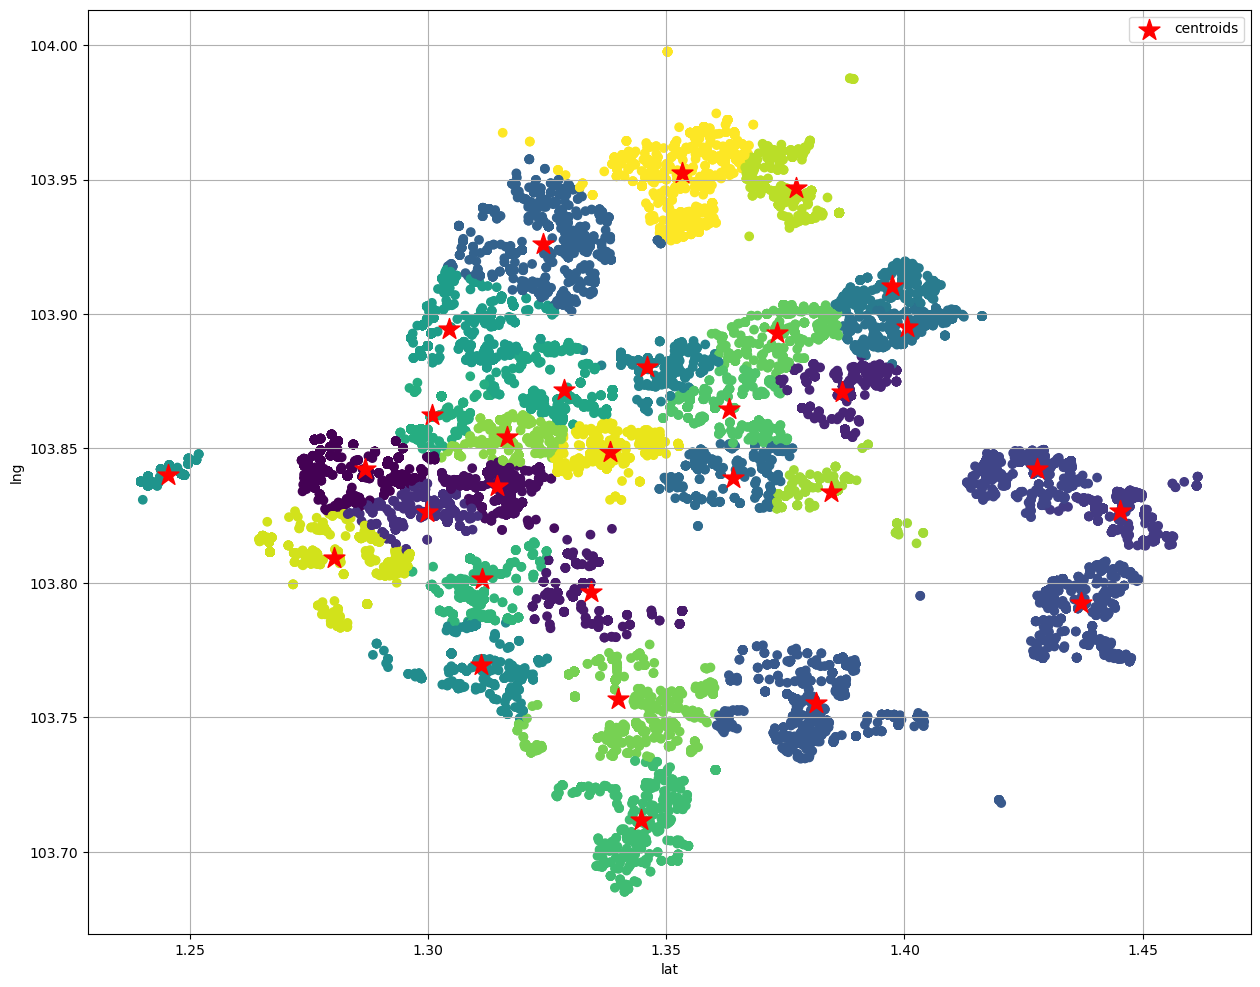

In [12]:
km = kmeans_model(df_train_simple,30)
cluster_plot(km, df_train_simple, 30)

In [13]:
new_clustered_data = get_clusters(km, df_train_simple, 30)
new_clustered_data

,lat,lng,cluster
0,1.414399,103.837196,6
1,1.372597,103.875625,21
2,1.298773,103.895798,16
3,1.312364,103.803271,19
4,1.273959,103.843635,0
...,...,...,...
20091,1.385938,103.834466,25
20092,1.315948,103.857589,24
20093,1.315961,103.836848,1
20094,1.440753,103.806671,7


In [14]:

score = []
for k in range(2,30):
    kmeans = KMeans(n_clusters=k,random_state=4)
    kmeans.fit(df_train_simple)
    labels = kmeans.labels_
    ss = silhouette_score(df_train_simple,labels)
    score.append(ss)

Text(0.5, 0, 'no of clusters')

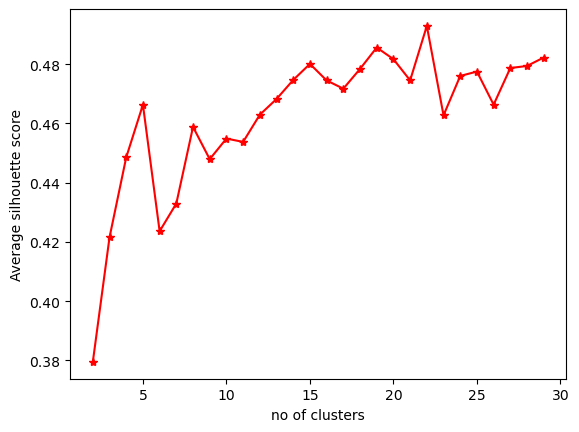

In [15]:
plt.plot(range(2,30), score, marker='*',color='r')
plt.ylabel('Average silhouette score')
plt.xlabel('no of clusters')

## Testing the Recommendation Engine

This will be the main part of your notebook to allow for testing your solutions. Most basically, for a given listing (defined by the row id in your input dataframe), we would like to see the recommendations you make. So however you set up your notebook, it should have at least a comparable section that will allow us to run your solution for different inputs.

### Pick a Sample Listing as Input

In [28]:
# Pick a row id of choice
#row_id = 10
row_id = 20
#row_id = 30
#row_id = 40
#row_id = 50

# Get the row from the dataframe (an valid row ids will throw an error)
row_location = df_test.iloc[row_id][["lat", "lng"]]
row = df_test.iloc[row_id]
test_data = pd.DataFrame([row])
test_data

# Just for printing it nicely, we create a new dataframe from this single row
# pd.DataFrame([row])

,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,...,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
20,executive condo,2027.0,4.0,4.0,1335,616.0,1.434928,103.845282,yishun east,yishun,...,1157.798811,1231.474343,1.143726e+06,8.0,166.875,1.466825e+06,1.294509,2.0,1,0


In [29]:
y_km = km.predict(pd.DataFrame([row_location]))
y_km

array([6], dtype=int32)

In [30]:
one_clustered_data = df_train[new_clustered_data["cluster"] == y_km[0]]
one_clustered_data

,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,...,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
0,hdb,1988,3.0,2.0,1115,116,1.414399,103.837196,yishun south,yishun,...,1079.757868,1231.474343,1.143726e+06,5.0,223.000000,6.620452e+05,0.573567,2.0,1,0
35,hdb,2017,3.0,2.0,1001,588,1.424190,103.844932,yishun east,yishun,...,1079.757868,1231.474343,1.143726e+06,5.0,200.200000,6.620452e+05,1.248138,2.0,1,0
68,executive condo,2014,3.0,3.0,1184,406,1.424329,103.848225,yishun east,yishun,...,1157.798811,1231.474343,1.143726e+06,6.0,197.333333,1.466825e+06,1.576111,2.0,1,0
103,executive condo,2017,4.0,3.0,1185,525,1.417017,103.845035,lower seletar,yishun,...,1157.798811,1231.474343,1.143726e+06,7.0,169.285714,1.466825e+06,1.342132,2.0,1,0
113,condo,2019,3.0,2.0,786,660,1.435032,103.844333,yishun east,yishun,...,1154.798804,1231.474343,1.143726e+06,5.0,157.200000,2.919816e+06,1.208111,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20028,executive condo,2027,3.0,2.0,969,616,1.434928,103.845282,yishun east,yishun,...,1157.798811,1231.474343,1.143726e+06,5.0,193.800000,1.466825e+06,1.294509,2.0,1,0
20046,hdb,2016,3.0,2.0,1220,375,1.416505,103.843626,lower seletar,yishun,...,1079.757868,1231.474343,1.143726e+06,5.0,244.000000,6.620452e+05,1.188673,2.0,1,0
20049,hdb,1986,4.0,2.0,1442,132,1.424190,103.844932,yishun east,yishun,...,1079.757868,1231.474343,1.143726e+06,6.0,240.333333,6.620452e+05,1.248138,2.0,1,0
20050,hdb,1987,2.0,2.0,688,137,1.423367,103.832617,yishun west,yishun,...,1079.757868,1231.474343,1.143726e+06,4.0,172.000000,6.620452e+05,0.662923,2.0,1,0


In [19]:
new_clustered_data[new_clustered_data["cluster"] == y_km[0]]


,lat,lng,cluster
0,1.414399,103.837196,6
35,1.424190,103.844932,6
68,1.424329,103.848225,6
103,1.417017,103.845035,6
113,1.435032,103.844333,6
...,...,...,...
20028,1.434928,103.845282,6
20046,1.416505,103.843626,6
20049,1.424190,103.844932,6
20050,1.423367,103.832617,6


In [24]:
from sklearn.neighbors import NearestNeighbors

class Recommender:
    def __init__(self, X, k=10):
        self.X = X


    def feature_selection(self, feature_list):
        return self.X[feature_list]


    def train_model(self, model_input):
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(model_input)
        return nbrs
    
    def predict_k(self, nbrs, predict_input_data):
        distances, indices = nbrs.kneighbors(predict_input_data)
        return indices


    def find_house_recommendations(self, recommendations, visited_house_history, num_of_recom = k):
        filtered_houses = recommendations.iloc[visited_house_history]
        return filtered_houses

In [25]:
def get_top_recommendations(row, **kwargs) -> pd.DataFrame:
    
    #####################################################
    ## Initialize the required parameters
    
    # The number of recommendations seem recommended
    # Additional input parameters are up to you
    k = None
    
    # Extract all **kwargs input parameters
    # and set the used paramaters (here: k)
    for key, value in kwargs.items():
        if key == 'k':
            k = value
        if key == 'recommendations_input':
           recommendations_input = value
            
       
    #####################################################
    ## Compute your recommendations
    #
    # This is where your magic happens. Of course, you can call methods
    # defined in this notebook or in external Python (.py) scripts
    #
        
    # Here, we just return the input row k times
    # Ideally, you recommendations will be much better
    #df_result = pd.DataFrame([row] * k, index=None)
    print(len(recommendations_input))


    obj = Recommender(recommendations_input)
    model_input = obj.feature_selection(['size_per_room','num_baths','num_beds','size_sqft'])
    k_model = obj.train_model(model_input)
    predict_input_data = row[['size_per_room','num_baths','num_beds','size_sqft']]
    recommendations_out = obj.predict_k(k_model, predict_input_data)
    # print(recommendations_out)


    recommen_input_data = recommendations_input.copy()
    recommen_input_data1 = recommen_input_data.reset_index()
    out_idx = recommendations_out[0].tolist()
    
    df_result = obj.find_house_recommendations(recommen_input_data1, out_idx, num_of_recom = k)
    print(df_result.shape)

    return df_result


## Compute and Display the recommendations

Since the method `get_top_recommendations()` returns a `pd.DataFrame`, it's easy to display the result.

In [31]:
k = 10

df_recommendations = get_top_recommendations(test_data, k=k, recommendations_input=one_clustered_data)
df_recommendations

745
(10, 27)


,index,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,...,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
221,5837,executive condo,2027,4.0,4.0,1335,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,166.875000,1.466825e+06,1.294509,2.0,1,0
553,14672,executive condo,2027,4.0,4.0,1335,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,166.875000,1.466825e+06,1.294509,2.0,1,0
368,9439,executive condo,2027,4.0,4.0,1335,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,166.875000,1.466825e+06,1.294509,2.0,1,0
205,5484,executive condo,2027,4.0,4.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,164.125000,1.466825e+06,1.294509,2.0,1,0
186,4829,executive condo,2027,4.0,4.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,164.125000,1.466825e+06,1.294509,2.0,1,0
448,11668,executive condo,2027,4.0,4.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,164.125000,1.466825e+06,1.294509,2.0,1,0
265,6924,executive condo,2027,4.0,4.0,1313,616,1.434218,103.844532,yishun east,...,1157.798811,1231.474343,1.143726e+06,8.0,164.125000,1.466825e+06,1.184451,2.0,1,0
652,17663,executive condo,2027,4.0,3.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,7.0,187.571429,1.466825e+06,1.294509,2.0,1,0
121,3022,executive condo,2027,4.0,3.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,7.0,187.571429,1.466825e+06,1.294509,2.0,1,0
730,19769,executive condo,2027,4.0,3.0,1313,616,1.434928,103.845282,yishun east,...,1157.798811,1231.474343,1.143726e+06,7.0,187.571429,1.466825e+06,1.294509,2.0,1,0
